In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecgdata/records/A16449.h5
/kaggle/input/ecgdata/records/A14772.h5
/kaggle/input/ecgdata/records/A06579.h5
/kaggle/input/ecgdata/records/A06020.h5
/kaggle/input/ecgdata/records/A15854.h5
/kaggle/input/ecgdata/records/A25124.h5
/kaggle/input/ecgdata/records/A10882.h5
/kaggle/input/ecgdata/records/A20436.h5
/kaggle/input/ecgdata/records/A14168.h5
/kaggle/input/ecgdata/records/A00287.h5
/kaggle/input/ecgdata/records/A24565.h5
/kaggle/input/ecgdata/records/A06196.h5
/kaggle/input/ecgdata/records/A04792.h5
/kaggle/input/ecgdata/records/A08363.h5
/kaggle/input/ecgdata/records/A19882.h5
/kaggle/input/ecgdata/records/A07381.h5
/kaggle/input/ecgdata/records/A25292.h5
/kaggle/input/ecgdata/records/A05021.h5
/kaggle/input/ecgdata/records/A07346.h5
/kaggle/input/ecgdata/records/A17492.h5
/kaggle/input/ecgdata/records/A13580.h5
/kaggle/input/ecgdata/records/A12596.h5
/kaggle/input/ecgdata/records/A14540.h5
/kaggle/input/ecgdata/records/A04699.h5
/kaggle/input/ecgdata/records/A14519.h5


In [19]:
import matplotlib.pyplot as plt
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [20]:
# device = "cuda"
device = "cpu"

class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, kernel_size=7):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # self.conv = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size, padding=0)
        
        # self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size//4)

        self.l_relu = nn.LeakyReLU()

        self.fc2 = nn.Linear(hidden_size//4, output_size)
        
        self.sigmoid = nn.Sigmoid()

        self.batchnorm1 = nn.BatchNorm1d(12)

    def forward(self, x):
        # Применяем сверточный слой
        
        # x = x.permute(0, 2, 1)  # (batch_size, seq_len, input_size) -> (batch_size, input_size, seq_len)
        
        # x = self.conv(x)        # (batch_size, hidden_size, seq_len)
        # x = x.permute(0, 2, 1)  # (batch_size, seq_len, hidden_size)

        x = x.permute(0, 2, 1)  # (batch_size, seq_len, input_size)
        
        x = self.batchnorm1(x)        # (batch_size, hidden_size, seq_len)
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, input_size)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.dropout(out[:, -1, :])   # Берем только последний выход LSTM
        
        out = self.fc1(out)
        out = self.l_relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)             # Применяем сигмоиду для получения вероятности
        return out

def load_data_kaggle(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('/kaggle/input/metadata/metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])
     
        # Считываем файл.
        with h5py.File(f'/kaggle/input/ecgdata/records/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")
    return signals, labels

def load_data(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def signal_transform_tensor_12(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    results_reshape = []

    scaler = MinMaxScaler()
    for i in range(12):
        results_reshape.append(np.reshape([nk.ecg_clean(signal[i][0:max_len_signal], sampling_rate=sampling_rate) for signal in signals], (1, max_len_signal * len(signals))))

    result_reshape = np.concatenate(results_reshape)

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1,2,0))

def signal_transform_tensor_12_scaled(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    results_reshape = []

    scaler = MinMaxScaler()
    for i in range(12):
        # results_reshape.append(np.reshape([nk.ecg_clean(signal[i][0:max_len_signal], sampling_rate=sampling_rate) for signal in signals], (1, max_len_signal * len(signals))))
        s = [scaler.fit_transform(signal[i][0:max_len_signal].reshape(-1, 1)).reshape(max_len_signal) for signal in signals]
        
        results_reshape.append(np.reshape(s, (1, max_len_signal * len(signals))))

    result_reshape = np.concatenate(results_reshape)

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

def pipeline_0_model_iteration(N, save_weights_name, num_epochs=10, lr=0.01, momentum=0.9, weight_decay=0.0001, plot=False):
    metadata_filepath = 'metadata.csv'
    sample_freq = 500

    # Загружаем данные
    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N)

    # Трансформируем данные для обучения
    signals_12_transformed = signal_transform_tensor_12(signals, max_len_signal=500)

    labels_transformed = label_transform_tensor(labels)

    # Разделение данных на вход (X) и метки (y)
    X = signals_12_transformed.to(device)  # (batch_size, seq_len, input_size)
    y = labels_transformed.to(device)

    # Создание TensorDataset
    dataset = TensorDataset(X, y)

    # Разделение на обучающую и тестовую выборки
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Создание DataLoader
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Параметры модели
    input_size = 12
    hidden_size = 50
    output_size = 1  # Один выход для бинарной классификации
    num_layers = 4

    model_0 = LSTMBinaryClassifier(input_size, hidden_size, output_size, num_layers, 1).to(device)

    print("Model initialized\n")

    # Определение функции потерь и оптимизатора
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    # optimizer = torch.optim.Adam(model_0.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = torch.optim.SGD(model_0.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    print("Model training...\n")
    # Обучение модели
    for epoch in range(num_epochs):
        model_0.train()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
        for batch_x, batch_y in progress_bar:
            optimizer.zero_grad()
            outputs = model_0(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            accuracy = (outputs.round() == batch_y).float().mean()
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Accuracy": f"{accuracy.item():.4f}"
            })

    # Оценка модели
    model_0.eval()
    correct = 0
    total = 0

    if plot:
        plt.figure(figsize=(10, 6))

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_0(batch_X)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            if plot:
                plt.plot(batch_y.tolist(), label='True Labels', marker='o', linestyle='None')
                plt.plot(predicted.tolist(), label='Predicted Labels', marker='x', linestyle='None')

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Визуализация результатов
    if plot:
        plt.legend()
        plt.show()

    torch.save(model_0.state_dict(), save_weights_name)

    return model_0

# if __name__=='__main__':
#     save_path = './weights/0/12_2048_SGD_10_0.0001_0.9_0.pth'

#     pipeline_0_model_iteration(64, save_path, _channel=0, lr=0.0001, momentum=0.9, plot=False)

Data loaded successfully.
          Health    number:     527
          Diseased  number:     497


Label transformed to tensor successfully

Model initialized

Model training...



Epoch 10/10: 100%|██████████| 26/26 [00:24<00:00,  1.05batch/s, Loss=0.7013, Accuracy=0.3684]


Test Accuracy: 0.5171


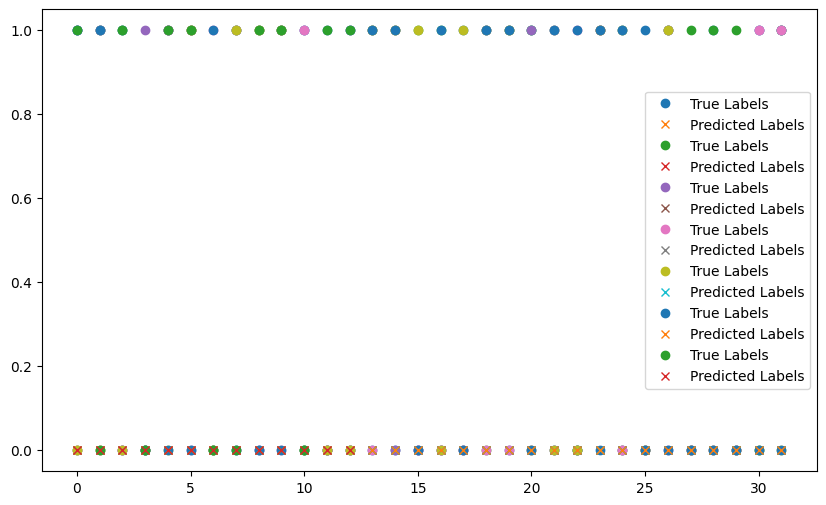

LSTMBinaryClassifier(
  (lstm): LSTM(12, 50, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=50, out_features=12, bias=True)
  (l_relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [21]:
# import gc

save_path = './weights/12_2048_SGD_10_0.0001_0.9_0.pth'

# gc.collect()

pipeline_0_model_iteration(1024, num_epochs=10, save_weights_name=save_path, lr=0.01, momentum=0.9, plot=True)

# torch.cuda.empty_cache()